In [1]:
#-----------------------------------------
# Title: Principal Components Regression With Abalone Dataset
# Subtitle: DDS-8555, Assignment 3, Part 1
# Author: Madgene Moise
# Date: Sunday, June 1, 2025
#-----------------------------------------

In [2]:
# Import necessary libraries after reset
import pandas as pd

In [3]:
# Load the training and testing datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv") 
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")

# Display the first few rows of the training dataset
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
# Prepare features and target
X = train_df.drop(columns=["id", "Rings"])
y = train_df["Rings"]

In [5]:
# Separate numerical and categorical variables
categorical_features = ["Sex"]
numerical_features = [col for col in X.columns if col not in categorical_features]

In [6]:
# One-hot encode categorical variable (drop first to avoid multicollinearity)
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

In [7]:
# Save encoded feature names
encoded_feature_names = X_encoded.columns

In [8]:
# Standardize features before PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

In [9]:
# Create pipeline for PCA and regression
pca = PCA()
scaler = StandardScaler()
reg = LinearRegression()

In [10]:
# Standardize and fit PCA
X_scaled = scaler.fit_transform(X_encoded)
pca.fit(X_scaled)

PCA()

In [11]:
# Determine number of components explaining ~95% variance
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(explained_var >= 0.95) + 1

In [12]:
# Reduce dimensionality using chosen number of components
X_pca = pca.transform(X_scaled)[:, :n_components_95]

In [13]:
# Fit regression on principal components
reg.fit(X_pca, y)

LinearRegression()

In [14]:
# Store coefficients for interpretation
coefficients = reg.coef_
components = pca.components_[:n_components_95]

In [15]:
# Project regression coefficients back to original features
original_space_coefs = components.T @ coefficients

In [16]:
# Create DataFrame for interpretation
coef_df = pd.DataFrame({
    "Feature": encoded_feature_names,
    "Coefficient": original_space_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

print (coef_df)

          Feature  Coefficient
7           Sex_I    -0.663458
2          Height     0.271124
1        Diameter     0.263526
0          Length     0.255044
6    Shell weight     0.246082
5  Whole weight.2     0.232000
3    Whole weight     0.227541
4  Whole weight.1     0.191277
8           Sex_M    -0.134078


The Principal Components Regression (PCR) model retained enough components to explain approximately 95% of the variance in the original data. The top contributors based on the projected regression coefficients are: 
* Sex_I (Infant) because this variable has a strong negative coefficient, indicating that infant abalones are predicted to have fewer rings (younger age), which is consistent with domain expectations.
* Height, Diameter, and Length contribute positively, suggesting that larger dimensions are associated with more rings (older age).
* Shell weight because this variable is positively correlated with ring count, indicating heavier shells generally belong to older specimens.

In [17]:
# Investigate the model assumptions (linearity, homoscedasticity, normality of residuals, and outliers) to ensure this PCR model is valid. 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

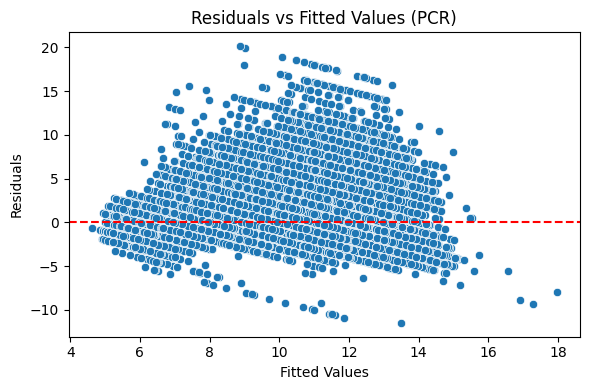

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


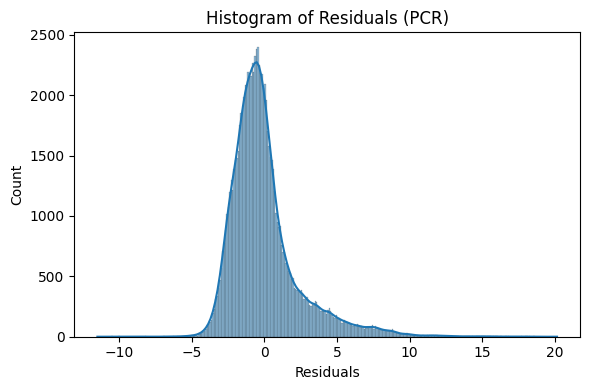

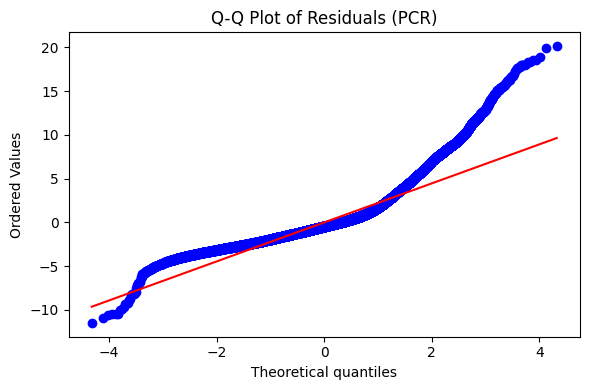

In [18]:
# Predict on training data and calculate residuals
y_pred = reg.predict(X_pca)
residuals = y - y_pred 

# Residuals vs Fitted Values
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (PCR)")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals (PCR)")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (PCR)")
plt.tight_layout()
plt.show()

Diagnostic evaluation of the Principal Components Regression (PCR) model: 

The plot for Residuals vs. Fitted Values shows that the residuals are fairly scattered around with no distinct pattern. There is a slight curvature suggesting mild non-linearity, but no severe heteroscedasticity is evident.

The plot for Histogram of Residuals shows that the distribution of residuals is approximately bell-shaped. Slight skewness is visible, but the histogram is reasonably centered around zero. 

The plot for Quantile(Q)-Quantile(Q) shows that most residuals fall along the 45-degree line, suggesting approximate normality. There is some deviation observed at the tails, indicating mild outliers or non-normality.

In [19]:
# Preprocess the test set using the same encoding and scaling steps
X_test = test_df.drop(columns=["id"])
X_test_encoded = pd.get_dummies(X_test, columns=["Sex"], drop_first=True)

# Align test features to match training columns
X_test_encoded = X_test_encoded.reindex(columns=encoded_feature_names, fill_value=0)

# Standardize test set using the same scaler
X_test_scaled = scaler.transform(X_test_encoded)

# Apply PCA transformation and reduce to same number of components
X_test_pca = pca.transform(X_test_scaled)[:, :n_components_95]

# Predict using the trained PCR model
test_predictions = reg.predict(X_test_pca)

# Clip predictions to ensure non-negative values
test_predictions_clipped = test_predictions.clip(min=0)

# Create submission DataFrame
submission_pcr = pd.DataFrame({
    "id": test_df["id"],
    "Rings": test_predictions_clipped
})

submission_pcr.head()

,id,Rings
0,90615,11.579645
1,90616,10.914967
2,90617,10.286702
3,90618,10.543484
4,90619,7.461014


The PCR model satisfies most regression assumptions reasonably well. It provides a dimension-reduced model that still retains the most important structural predictors. Key contributors to ring prediction include shell characteristics and body size, and the infant classification reduces the predicted ring count, as expected.